In [1]:
import numpy as np
import pandas as pd
import datetime
from math import log
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from tqdm import tqdm
import pickle

datos = pd.read_csv("Datos/tabla_precios_final.csv")

# Robot Optimizado de Medias y Bandas Bollinger

In [2]:
# Definimos una parent class que usaremos tanto en el robot de medias móviles como en el de Bandas de Bollinger 
class Robot_Basico():
    def __init__(self, capital, acciones = 0, posicion = "none"):
        self.capital = capital
        self.capital_inicial = self.capital
        self.acciones = acciones
        self.posicion = posicion
        self.margen_venta = 1 #USAMOS EL 100% COMO MARGEN
        self.margin_call_lim = 1 + 0.538461538461539 #Segun la FED cuanto tiene que subir el precio en un short listing para que tengas que añadir dinero a tu margen
        
    def compra(self, precio):
        '''Compramos todas las acciones con el capital disponible'''
        self.acciones = self.capital / precio
        self.capital = 0
        self.posicion = "compra"
        return

    def stopcompra(self, precio):
        self.capital += precio * self.acciones
        self.acciones = 0
        self.posicion = "none"
        return

    def venta(self, precio):
        self.acciones = - self.capital * (1 - self.margen_venta) / precio 
        self.capital += self.acciones * precio
        self.posicion = "venta"
        self.precio_venta = precio
        return

    def stopventa(self, precio):
        self.capital -= 2 * (self.precio_venta * self.acciones) - precio * self.acciones
        self.acciones = 0
        self.posicion = "none"
        return
        

In [5]:
class Simulador_Estrategia():
    def __init__(self,capital_inicial, lista_tickers, tabla_precios, dates):
        self.capital_total = capital_inicial
        self.lista_tickers = lista_tickers
        self.tabla_precios = tabla_precios
        self.dates = dates
        self.totales = {item: {} for item in self.lista_tickers}


class Simulador_Bandas_Bollinger(Simulador_Estrategia):
    
    @staticmethod
    def media_movil(precios, ventana):
        return pd.Series(precios).rolling(ventana).mean().to_numpy()
    
    @staticmethod
    def std_movil(precios, ventana):
        return pd.Series(precios).rolling(3).std().to_numpy()
        
    @staticmethod
    def calculo_pendiente(ventana_pend):
        '''Nueva función con la que a raiz de los valores contenidos en las ventanas temporales, se 
        calcularán las pendientes de las regresiones lineales móviles'''
        t = np.arange(len(ventana_pend))
        return np.polyfit(t, ventana_pend, 1)[0]  # [0] porque queremos solo la pendiente
    
    @staticmethod
    def tendencia_lateral(pendiente, limite):
        '''Nueva función con la que, en función del limite establecido, 
        consideraremos si una pendiente representa una tendencia lateral'''
        if np.isclose(pendiente, 0, atol = limite):
            return True
        return False
    
    @staticmethod
    def rentabilidad(capital_final, capital_inicial):
        return capital_final / capital_inicial - 1
    
    @classmethod
    def bollingers(cls, precios, ventana, num_std):
        '''Calcula las Bandas de Bollinger en funcion de los parametros introducidos'''
        bollinger_up = cls.media_movil(precios, ventana) + num_std * cls.std_movil(precios, ventana)
        bollinger_down = cls.media_movil(precios, ventana) - num_std * cls.std_movil(precios, ventana)
        return bollinger_up, bollinger_down
    
    @staticmethod
    def margin_call(robot, preciorobot):
        '''Simplemente cerramos la posicion al recibir el margin call'''
        robot.stopventa(preciorobot)
        return
    
    def simular(self, ventana = 8, ventana_pend = 8, num_std = 1, limite_pend = 0.1, calcular_pendientes = True, pendientes_series = {}):
        self.ventana = ventana
        self.ventana_pend = ventana_pend
        self.num_std = num_std # A diferencia del robot de medias moviles, incluimos el parametro de numero de desviaciones tipicas
        self.limite_pend = limite_pend
        self.pendientes_series = pendientes_series
        capital_por_accion = self.capital_total / len(self.lista_tickers)
        self.rentabilidades = dict(zip(self.lista_tickers, np.zeros(len(self.lista_tickers))))
        self.capital_final = dict(zip(self.lista_tickers, np.zeros(len(self.lista_tickers))))
        
        i = -1
        # En primer lugar se itera sobre los distintos activos (tickers)
        for ticker in self.lista_tickers:
            robot = Robot_Basico(capital_por_accion) # Generamos un robot por cada ticker
            i += 1
            precios = np.array(self.tabla_precios[:, i], dtype = "float") # Definimos y limpiamos los precios
            precios = precios[~np.isnan(precios)]
            
            if not list(precios):
                self.rentabilidades[ticker] = float("nan")
                self.capital_final[ticker] = robot.capital
                continue # Si no hay valores para un ticker saltamos al siguiente
                
            medias = self.media_movil(precios, self.ventana)
            bollinger_up, bollinger_down = Simulador_Bandas_Bollinger.bollingers(precios, self.ventana, self.num_std) # Definimos las distintas bandas
            if calcular_pendientes:
                self.pendientes_series[ticker] = pd.Series(precios).rolling(self.ventana_pend).apply(self.calculo_pendiente, raw=False)
            
            t = max(self.ventana, self.ventana_pend) - 1
            day = max(self.ventana, self.ventana_pend) - 1
            # Iteramos sobre los dias de trading
            while True:
                preciorobot = precios[t]
                mediarobot = medias[t]
                boluprobot = bollinger_up[t]
                boldownrobot = bollinger_down[t]
                pendienterobot = pendientes_series[ticker][t]
                
                # Implementamos la nueva lógica a seguir
                if robot.posicion == "none":
                    if (preciorobot < mediarobot and 
                    self.tendencia_lateral(pendienterobot, self.limite_pend)) or (
                    pendienterobot > 0 and not self.tendencia_lateral(pendienterobot, self.limite_pend)):
                        robot.compra(preciorobot)
                    
                    elif (preciorobot > mediarobot and
                    self.tendencia_lateral(pendienterobot, self.limite_pend)) or (
                    pendienterobot > 0 and not self.tendencia_lateral(pendienterobot, self.limite_pend)):
                        robot.venta(preciorobot)# Implementamos la logica a seguir
                if robot.posicion == "none":
                    if preciorobot < mediarobot and self.tendencia_lateral(pendienterobot, self.limite_pend):
                        robot.compra(preciorobot)
                    
                    elif preciorobot > mediarobot and self.tendencia_lateral(pendienterobot, self.limite_pend):
                        robot.venta(preciorobot)
                
                else:
                    if robot.posicion == "compra" and ((preciorobot > boluprobot and
                    self.tendencia_lateral(pendienterobot, self.limite_pend)) or (
                    pendienterobot < 0 and not self.tendencia_lateral(pendienterobot, self.limite_pend))):
                        robot.stopcompra(preciorobot)
                    
                    if robot.posicion == "venta" and ((preciorobot < boldownrobot and
                    self.tendencia_lateral(pendienterobot, self.limite_pend)) or (
                    pendienterobot > 0 and not self.tendencia_lateral(pendienterobot, self.limite_pend))):
                        robot.stopventa(preciorobot)
                        
                
                if robot.posicion == "venta": 
                    if robot.precio_venta * robot.margin_call_lim < preciorobot:
                        self.margin_call(robot, preciorobot)

                
                # Cerramos posicion si es la ultima fecha, sino seguimos iterando
                if t == len(precios) - 1:
                    if robot.posicion == "compra":
                        robot.stopcompra(preciorobot)
                        self.rentabilidades[ticker] = self.rentabilidad(robot.capital, capital_por_accion)
                        self.capital_final[ticker] = robot.capital
                        self.totales[ticker][self.dates[day]] = [robot.capital, np.abs(robot.acciones * preciorobot)]
                        break
                        
                    elif robot.posicion == "venta":
                        robot.stopventa(preciorobot)
                        self.rentabilidades[ticker] = self.rentabilidad(robot.capital, capital_por_accion)
                        self.capital_final[ticker] = robot.capital
                        self.totales[ticker][self.dates[day]] = [robot.capital, np.abs(robot.acciones * preciorobot)]
                        break
                    
                    elif robot.posicion == "none":
                        self.rentabilidades[ticker] = self.rentabilidad(robot.capital, capital_por_accion)
                        self.capital_final[ticker] = robot.capital
                        self.totales[ticker][self.dates[day]] = [robot.capital, np.abs(robot.acciones * preciorobot)]
                        break
                
                else:
                    self.totales[ticker][self.dates[day]] = [robot.capital, np.abs(robot.acciones * preciorobot)]
                    t += 1
                    day += 1
        return

In [14]:
# Definimos todas las funciones que utilizaremos posteriormente para los diferentes robots concretos
def Ejecutar_Simulador_BandasBollinger(year, capital_inicial, ventana, ventana_pend, num_std, 
                                       limite_pend, calcular_pendientes = True, pendientes_series = {}):
    dataframe = datos[(pd.to_datetime(datos.Date) >= pd.Timestamp(datetime.date(year, 1, 1)))]
    tabla_precios = dataframe.iloc[:, 1:].to_numpy()
    lista_tickers = dataframe.iloc[:, 1:].columns
    dates = dataframe.Date.reset_index(drop = True)

    simulador = Simulador_Bandas_Bollinger(capital_inicial, lista_tickers, tabla_precios, dates)
    simulador.simular(ventana = ventana, num_std = num_std, ventana_pend = ventana_pend, 
                      limite_pend = limite_pend, calcular_pendientes = calcular_pendientes, 
                      pendientes_series = pendientes_series)
    return simulador

def Histograma_Rentabilidades(simulador, year = 2017, capital_inicial = 10000000):
    plt.figure(figsize = (8, 5))
    plt.hist(simulador.rentabilidades.values(), bins = np.linspace(-1, 1.5, 100))
    plt.title(f"Rentabilidades individuales desde el año {year}", fontsize = 15)
    plt.show()
    print(pd.Series(simulador.rentabilidades.values()).describe())
    r_total = round(simulador.rentabilidad(sum(simulador.capital_final.values()), capital_inicial) * 100, 4)
    print(f"La rentabilidad total del robot desde el año {year} fue de {r_total}%\n")
    return

def Transformacion_Datos(simulador):
    '''Transforma las salidas de los resultados del simulador a una estructura 
    que posteriormente se utilizara para visualizar la evolucion temporal del efectivo y el capital'''
    provisional = pd.DataFrame(simulador.totales)
    provisional.fillna(method='ffill', inplace=True)
    provisional = provisional.applymap(lambda x: provisional["AAPL"].iloc[0] if pd.isna([x]).any() else x)
    
    def row_sum(row):
        '''Definimos una funcion para hacer la transformacion de las filas a traves del metodo .apply()'''
        element1_sum = sum(row[col][0] for col in provisional.columns)
        element2_sum = sum(row[col][1] for col in provisional.columns)
        element1_and_2_sum = element1_sum + element2_sum
        return pd.Series({"Efectivo": element1_sum, "Invertido": element2_sum, "Total": element1_and_2_sum})
    
    return provisional.apply(row_sum, axis=1)

def Evolucion_Capital(data_transformada):
    plt.figure(figsize = (8, 5))
    plt.fill_between(data_transformada.index, data_transformada['Total'], label='Invertido',alpha=1)
    plt.fill_between(data_transformada.index, data_transformada['Efectivo'], label='Efectivo',alpha=1)
    plt.plot(data_transformada["Total"])
    plt.legend()
    plt.xticks(data_transformada.index[::120], rotation = 45) # Establecemos que los xticks sean cada 120 dias
    plt.ylabel('Values')
    plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('%.f'))
    plt.show()
    return

def Mostrar_KPIs(data_transformada):
    total_return = ((data_transformada.Total[-1] / data_transformada.Total[0]) - 1)
    print("Total Return: {:.2f}%".format(total_return * 100))
    annualized_return = ((data_transformada.Total[-1] / data_transformada.Total[0]) ** (252 / len(data_transformada.Total)) - 1)
    print("Annualized Return: {:.2f}%".format(annualized_return * 100))
    volatility = data_transformada.Total.pct_change().std() * np.sqrt(252)
    print("Volatility: {:.2f}%".format(volatility * 100))
    cumulative_returns = (1 + data_transformada.Total.pct_change()).cumprod()
    cumulative_returns.iloc[0] = 1
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()
    print("Maximum Drawdown: {:.2f}%".format(max_drawdown * 100))
    daily_returns = data_transformada.Total.pct_change()
    daily_returns.index = pd.to_datetime(daily_returns.index)
    daily_risk_free = pd.read_csv("Datos/F-F_Research_Data_Factors_daily-3.csv", index_col = 0)
    daily_risk_free.index = pd.to_datetime(daily_risk_free.index, format='%Y%m%d')
    daily_risk_free = daily_risk_free[daily_risk_free.index >= pd.to_datetime("2017-01-01")].RF
    daily_risk_free = daily_risk_free[daily_risk_free.index <= pd.to_datetime("2022-10-31")]
    daily_risk_free = daily_risk_free / 100
    daily_excess_returns = (daily_returns - daily_risk_free).dropna()
    mean_daily_excess_returns = daily_excess_returns.mean()
    daily_volatility_er = daily_excess_returns.std()
    daily_sharpe_ratio = mean_daily_excess_returns / daily_volatility_er
    sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
    print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))
    return  

## Estudio de nuevos parámetros para el robot óptimo de Bandas de Bollinger  (Ventana = 5, Std = 3.5)

In [34]:
### CUIDADO CON EJECUTAR, TARDA 2 HORAS###
rentabilidades_v5std35_ventanapend_limite_BB = {}
year = 2017
capital_inicial = 10000000
num_std = 3.5
ventana = 5
# Vamos a dejar fijo el valor de std optimizado previamente (3.5) y el de tamaño de ventana
ventanas_pend = [5, 10, 20, 40, 80, 160]

for ventana_pend in ventanas_pend:
    i = 0
    rentabilidades_v5std35_ventanapend_limite_BB[ventana_pend] = []
    for limite_pend in tqdm(range(1, 150,2)):
        # Dividimos entre primera iter y el resto para no tener que recalcular las regresiones por cada limite, optimizamos mucho el bucle
        if i == 0:
            limite_pend = limite_pend / 100
            simulador = Ejecutar_Simulador_BandasBollinger(year = year, capital_inicial = capital_inicial, 
                                                           ventana = ventana, ventana_pend = ventana_pend,
                                                           num_std = num_std, limite_pend = limite_pend)
            r_total = round(simulador.rentabilidad(sum(simulador.capital_final.values()), capital_inicial) * 100, 4)
            rentabilidades_v5std35_ventanapend_limite_BB[ventana_pend].append(r_total)
            i += 1
        else:
            limite_pend = limite_pend / 100
            simulador = Ejecutar_Simulador_BandasBollinger(year = year, capital_inicial = capital_inicial, 
                                                           ventana = ventana, ventana_pend = ventana_pend, num_std = num_std, 
                                                           limite_pend = limite_pend, calcular_pendientes = False,
                                                           pendientes_series = simulador.pendientes_series)
            r_total = round(simulador.rentabilidad(sum(simulador.capital_final.values()), capital_inicial) * 100, 4)
            rentabilidades_v5std35_ventanapend_limite_BB[ventana_pend].append(r_total)
            

100%|███████████████████████████████████████████| 75/75 [24:50<00:00, 19.87s/it]


In [35]:
with open("rentabilidades_v5std35_ventanapend_limite_BB.pkl", 'wb') as file:
    pickle.dump(rentabilidades_v5std35_ventanapend_limite_BB, file)
    

In [40]:
# Mostramos el Top 3 limites por cada valor de ventana (en rentabilidad)
for ventana_pen, lista in rentabilidades_v5std35_ventanapend_limite_BB.items():
    # Obtener los tres valores máximos junto con sus posiciones
    top_valores = sorted(enumerate(lista), key=lambda x: x[1], reverse=True)[:3]
    
    print("Ventana:", ventana_pen)
    for posicion, valor in top_valores:
        print("Rentabilidad:", valor, "Límite pend:", (posicion * 2 + 1) / 100)
    print()

Ventana: 5
Rentabilidad: 50.1715 Límite pend: 0.01
Rentabilidad: 49.4375 Límite pend: 0.05
Rentabilidad: 49.0679 Límite pend: 0.09

Ventana: 10
Rentabilidad: 61.6254 Límite pend: 0.03
Rentabilidad: 55.9546 Límite pend: 0.01
Rentabilidad: 55.7556 Límite pend: 0.09

Ventana: 20
Rentabilidad: 56.1987 Límite pend: 0.09
Rentabilidad: 54.2063 Límite pend: 0.07
Rentabilidad: 52.1505 Límite pend: 0.15

Ventana: 40
Rentabilidad: 42.6292 Límite pend: 1.49
Rentabilidad: 42.5947 Límite pend: 1.47
Rentabilidad: 41.8188 Límite pend: 1.43

Ventana: 80
Rentabilidad: 46.6893 Límite pend: 1.29
Rentabilidad: 46.4903 Límite pend: 1.33
Rentabilidad: 46.3879 Límite pend: 1.45

Ventana: 160
Rentabilidad: 48.8525 Límite pend: 1.35
Rentabilidad: 48.8284 Límite pend: 1.37
Rentabilidad: 48.8093 Límite pend: 1.29



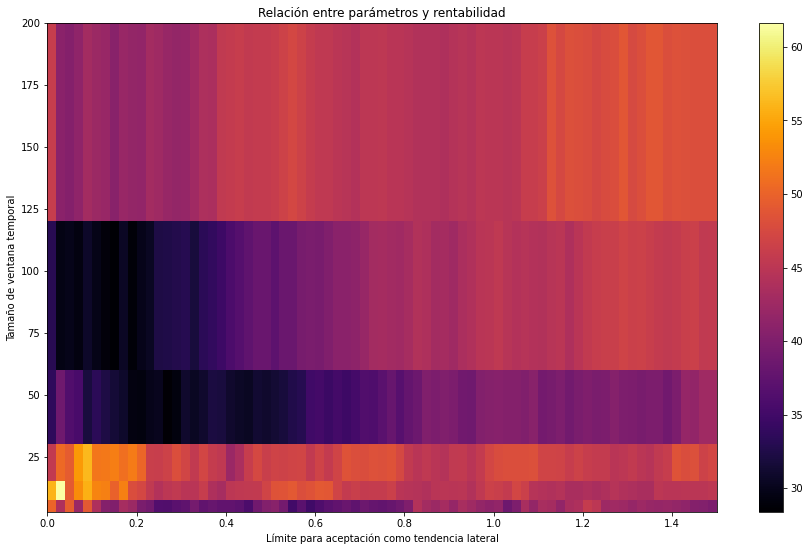

In [41]:
rendimientos = np.array(list(rentabilidades_v5std35_ventanapend_limite_BB.values()))  # Convertimos los rendimientos en un array de numpy

X, Y = np.meshgrid(np.arange(1, 150, 2) / 100, np.array(ventanas_pend)) # Creamos la matriz de rendimiento para la combinación de los distintos parámetros

# Graficamos la matriz de rendimientos
plt.figure(figsize=(15, 9)) 
plt.pcolormesh(X, Y, rendimientos, shading='auto', cmap='inferno')
plt.colorbar()  # Agrega una barra de color para indicar los valores de rendimiento
plt.ylabel('Tamaño de ventana temporal')
plt.xlabel('Límite para aceptación como tendencia lateral')
plt.title('Relación entre parámetros y rentabilidad')
plt.show()

## Zoom en zona de valores óptimos

In [50]:
rentabilidades_v5std35bis_ventanapend_limite_BB = {}
year = 2017
capital_inicial = 10000000
num_std = 3.5
ventana = 5
# Vamos a dejar fijo el valor de std optimizado previamente (3.5) y el de tamaño de ventana
ventanas_pend = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for ventana_pend in ventanas_pend:
    i = 0
    rentabilidades_v5std35bis_ventanapend_limite_BB[ventana_pend] = []
    for limite_pend in tqdm(range(1, 11)):
        # Dividimos entre primera iter y el resto para no tener que recalcular las regresiones por cada limite, optimizamos mucho el bucle
        if i == 0:
            limite_pend = limite_pend / 200
            simulador = Ejecutar_Simulador_BandasBollinger(year = year, capital_inicial = capital_inicial, 
                                                           ventana = ventana, ventana_pend = ventana_pend,
                                                           num_std = num_std, limite_pend = limite_pend)
            r_total = round(simulador.rentabilidad(sum(simulador.capital_final.values()), capital_inicial) * 100, 4)
            rentabilidades_v5std35bis_ventanapend_limite_BB[ventana_pend].append(r_total)
            i += 1
        else:
            limite_pend = limite_pend / 200
            simulador = Ejecutar_Simulador_BandasBollinger(year = year, capital_inicial = capital_inicial, 
                                                           ventana = ventana, ventana_pend = ventana_pend, num_std = num_std, 
                                                           limite_pend = limite_pend, calcular_pendientes = False,
                                                           pendientes_series = simulador.pendientes_series)
            r_total = round(simulador.rentabilidad(sum(simulador.capital_final.values()), capital_inicial) * 100, 4)
            rentabilidades_v5std35bis_ventanapend_limite_BB[ventana_pend].append(r_total)
            

100%|███████████████████████████████████████████| 10/10 [03:28<00:00, 20.87s/it]


In [51]:
with open("rentabilidades_v5std35bis_ventanapend_limite_BB.pkl", 'wb') as file:
    pickle.dump(rentabilidades_v5std35bis_ventanapend_limite_BB, file)
    

In [52]:
# Mostramos el Top 3 limites por cada valor de ventana (en rentabilidad)
for ventana_pen, lista in rentabilidades_v5std35bis_ventanapend_limite_BB.items():
    # Obtener los tres valores máximos junto con sus posiciones
    top_valores = sorted(enumerate(lista), key=lambda x: x[1], reverse=True)[:3]
    
    print("Ventana:", ventana_pen)
    for posicion, valor in top_valores:
        print("Rentabilidad:", valor, "Límite pend:", (posicion + 1) / 200)
    print()

Ventana: 5
Rentabilidad: 51.9512 Límite pend: 0.005
Rentabilidad: 50.7551 Límite pend: 0.045
Rentabilidad: 50.1715 Límite pend: 0.01

Ventana: 6
Rentabilidad: 84.0837 Límite pend: 0.005
Rentabilidad: 74.5597 Límite pend: 0.01
Rentabilidad: 69.3212 Límite pend: 0.04

Ventana: 7
Rentabilidad: 53.5433 Límite pend: 0.005
Rentabilidad: 41.2264 Límite pend: 0.01
Rentabilidad: 40.6933 Límite pend: 0.035

Ventana: 8
Rentabilidad: 48.2252 Límite pend: 0.005
Rentabilidad: 46.5907 Límite pend: 0.01
Rentabilidad: 44.9453 Límite pend: 0.03

Ventana: 9
Rentabilidad: 45.4148 Límite pend: 0.005
Rentabilidad: 44.178 Límite pend: 0.01
Rentabilidad: 43.3242 Límite pend: 0.04

Ventana: 10
Rentabilidad: 63.9648 Límite pend: 0.035
Rentabilidad: 61.6254 Límite pend: 0.03
Rentabilidad: 56.0509 Límite pend: 0.005

Ventana: 11
Rentabilidad: 54.3728 Límite pend: 0.005
Rentabilidad: 52.7962 Límite pend: 0.05
Rentabilidad: 52.5374 Límite pend: 0.03

Ventana: 12
Rentabilidad: 64.7591 Límite pend: 0.02
Rentabilidad:

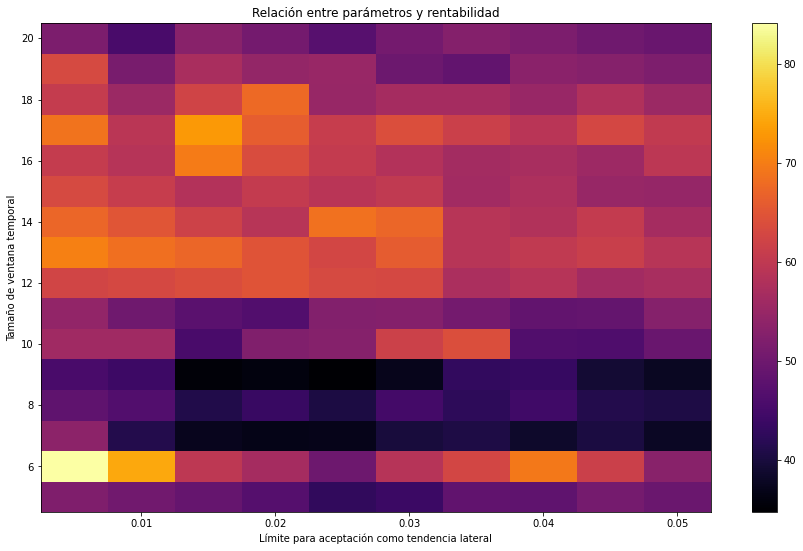

In [53]:
rendimientos = np.array(list(rentabilidades_v5std35bis_ventanapend_limite_BB.values()))  # Convertimos los rendimientos en un array de numpy

X, Y = np.meshgrid(np.arange(1, 11) / 200, np.array(ventanas_pend)) # Creamos la matriz de rendimiento para la combinación de los distintos parámetros

# Graficamos la matriz de rendimientos
plt.figure(figsize=(15, 9)) 
plt.pcolormesh(X, Y, rendimientos, shading='auto', cmap='inferno')
plt.colorbar()  # Agrega una barra de color para indicar los valores de rendimiento
plt.ylabel('Tamaño de ventana temporal')
plt.xlabel('Límite para aceptación como tendencia lateral')
plt.title('Relación entre parámetros y rentabilidad')
plt.show()

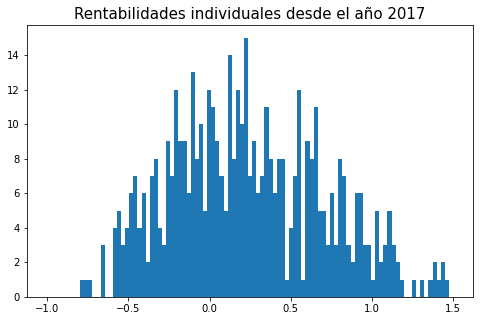

count    505.000000
mean       0.840837
std       10.373863
min       -0.783771
25%       -0.105814
50%        0.225243
75%        0.654629
max      232.472922
dtype: float64
La rentabilidad total del robot desde el año 2017 fue de 84.0837%



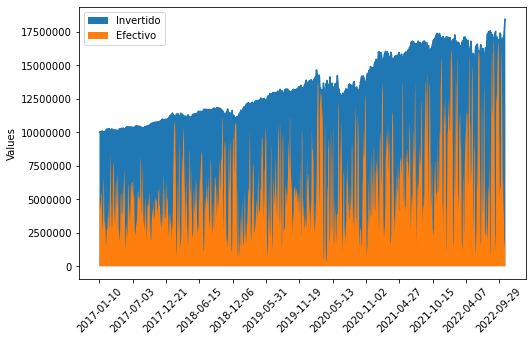

Total Return: 84.08%
Annualized Return: 11.08%
Volatility: 11.49%
Maximum Drawdown: -13.47%
Sharpe Ratio: 0.88


In [15]:
simulador = Ejecutar_Simulador_BandasBollinger(year = 2017, capital_inicial = 10000000, 
                                                           ventana = 5, ventana_pend = 6,
                                                           num_std = 3.5, limite_pend = 0.005)

Histograma_Rentabilidades(simulador)

Evolucion_Capital(Transformacion_Datos(simulador))

Mostrar_KPIs(Transformacion_Datos(simulador))

## Prueba con límite = 0 --> Sin hacer uso de la estrategia inicial

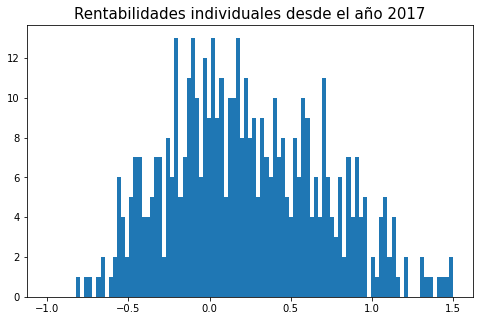

count    505.000000
mean       0.560284
std        4.298316
min       -0.810807
25%       -0.098495
50%        0.224454
75%        0.655075
max       94.882033
dtype: float64
La rentabilidad total del robot desde el año 2017 fue de 56.0284%



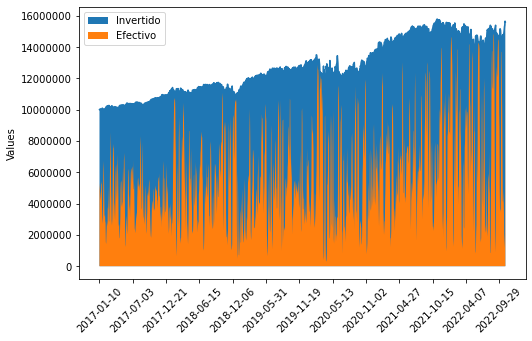

Total Return: 56.03%
Annualized Return: 7.96%
Volatility: 10.30%
Maximum Drawdown: -12.05%
Sharpe Ratio: 0.70


In [16]:
simulador = Ejecutar_Simulador_BandasBollinger(year = 2017, capital_inicial = 10000000, 
                                                           ventana = 5, ventana_pend = 6,
                                                           num_std = 3.5, limite_pend = 0)

Histograma_Rentabilidades(simulador)

Evolucion_Capital(Transformacion_Datos(simulador))

Mostrar_KPIs(Transformacion_Datos(simulador))